In [8]:
import torch
import os
import numpy as np
import torchvision
from torchvision import datasets, models, transforms


model_ft = models.resnet18(pretrained=True)
# feature_extractor = models.feature_extraction.create_feature_extractor(model_ft, {'avg_pool':'avgpool'})
num_ftrs = model_ft.fc.in_features

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [34]:
data_dir = './DATA/pacs/images/photo'
image_datasets = datasets.ImageFolder(data_dir, data_transform)
dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=2048,
                                             shuffle=True, num_workers=4)

dataset_sizes = len(image_datasets)
class_names = image_datasets.classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

# imshow(out, title=[class_names[x] for x in classes])

In [36]:
out_features = model_ft(inputs)

In [39]:
correlate_eps = 1e-3
mu = out_features
mu_squeeze = torch.squeeze(mu)
mean_mu = torch.mean(mu_squeeze, dim=0, keepdim=True)
correlation_mu = (mu_squeeze.T-mean_mu.T) @ (mu_squeeze-mean_mu)
eng_vector, eng_value = torch.linalg.eigh(correlation_mu)

In [40]:
print(torch.sum(eng_vector>(torch.max(eng_vector)*1e-2)))

tensor(55)


In [41]:
print(eng_vector)

tensor([-4.0852e-02, -2.3505e-02, -2.3173e-02, -2.2699e-02, -2.1841e-02,
        -2.0768e-02, -2.0549e-02, -2.0029e-02, -1.9985e-02, -1.9860e-02,
        -1.9364e-02, -1.9123e-02, -1.9063e-02, -1.8270e-02, -1.8179e-02,
        -1.7752e-02, -1.7649e-02, -1.6850e-02, -1.6684e-02, -1.6578e-02,
        -1.6541e-02, -1.6340e-02, -1.6041e-02, -1.5988e-02, -1.5915e-02,
        -1.5899e-02, -1.5659e-02, -1.5586e-02, -1.5099e-02, -1.4731e-02,
        -1.4701e-02, -1.4547e-02, -1.4538e-02, -1.4260e-02, -1.3961e-02,
        -1.3822e-02, -1.3712e-02, -1.3588e-02, -1.3548e-02, -1.3485e-02,
        -1.3473e-02, -1.3209e-02, -1.3202e-02, -1.3068e-02, -1.3014e-02,
        -1.2974e-02, -1.2923e-02, -1.2911e-02, -1.2489e-02, -1.2195e-02,
        -1.1875e-02, -1.1810e-02, -1.1576e-02, -1.1540e-02, -1.1515e-02,
        -1.1489e-02, -1.1455e-02, -1.1424e-02, -1.1253e-02, -1.1212e-02,
        -1.1007e-02, -1.0996e-02, -1.0925e-02, -1.0894e-02, -1.0762e-02,
        -1.0709e-02, -1.0603e-02, -1.0411e-02, -1.0

(array([[0., 1., 2., ..., 1., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 1., 0., 0.],
        ...,
        [0., 0., 2., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.57298344, -0.4198122 , -0.26664096, -0.1134697 ,  0.03970154,
         0.19287279,  0.34604403,  0.49921528,  0.65238655,  0.8055578 ,
         0.958729  ], dtype=float32),
 <a list of 1000 BarContainer objects>)

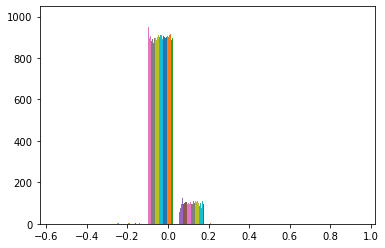

In [18]:
plt.plot(eng_value.detach().numpy())

In [ ]:
# This is for numerical stable
eng_vector[eng_vector<correlate_eps] = 0
mu_corr_matirx = torch.diag(torch.sqrt(eng_vector)) * (eng_value.T)

In [ ]:
import torch

class power_iteration_once(torch.autograd.Function):
    @staticmethod
    def forward(ctx, M, v_k, num_iter=19):
        '''
        :param ctx: used to save meterials for backward.
        :param M: n by n matrix.
        :param v_k: initial guess of leading vector.
        :return: v_k1 leading vector.
        '''
        ctx.num_iter = num_iter
        ctx.save_for_backward(M, v_k)
        return v_k

    @staticmethod
    def backward(ctx, grad_output):
        M, v_k = ctx.saved_tensors
        dL_dvk = grad_output
        I = torch.eye(M.shape[-1], out=torch.empty_like(M))
        numerator = I - v_k.mm(torch.t(v_k))
        denominator = torch.norm(M.mm(v_k)).clamp(min=1.e-5)
        ak = numerator / denominator
        term1 = ak
        q = M / denominator
        for i in range(1, ctx.num_iter + 1):
            ak = q.mm(ak)
            term1 += ak
        dL_dM = torch.mm(term1.mm(dL_dvk), v_k.t())
        return dL_dM, None